CBOW 모델의 문제점
- 말뭉치에 포함된 어휘가 많아지면 계산량도 커진다.  


목표 : word2vec의 속도 개선
- Embedding 이라는 새로운 계층 도입
- 네거티브 샘플링이라는 새로운 손실 함수 도입

# 4.1 word2vec 개선1

1. 입력층의 원핫 표현과 관련된 문제  
ex) 어휘가 100만 개라면 그 원핫 표현 하나만 해도 원소 수가 100만개인 벡터가 된다.  
상당한 메모리를 차지 한다. 따라서 Embedding 계층을 도입하는 것으로 해결한다.   
2. 은닉층 이후의 계산  
은닉층과 가중치 행렬 Wout의 곱만 해도 계산량이 상당함. Softmax 계층에서도 다루는 어휘가 많아짐에 따라 계산량이 증가하는 문제가 있음

## 4.1.1 Embedding 계층
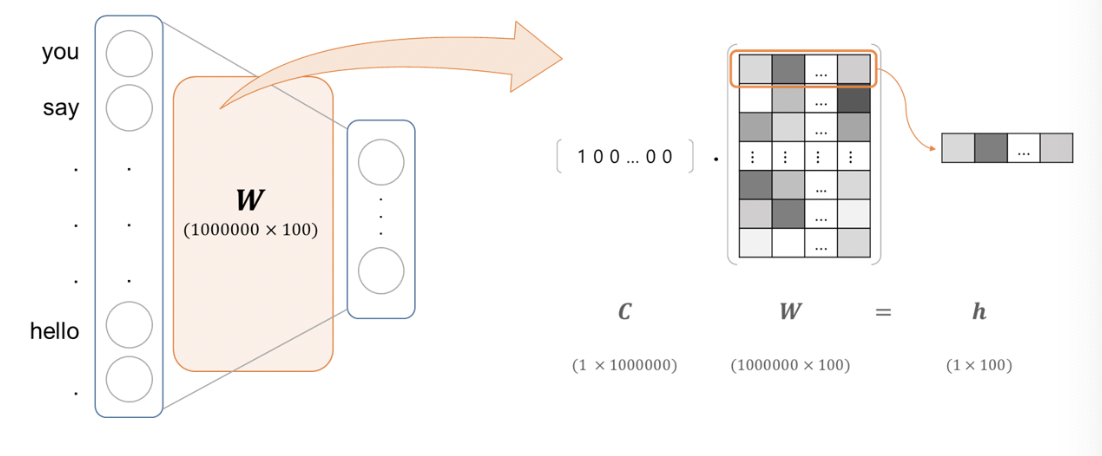

각 단어를 원핫 표현으로 변환한 다음 가중치 행렬을 곱해주는 작업은 **결과적으로 단지 각 단어에 해당하는 가중치 행렬의 특정 행을 추출하는 것일 뿐이다.** 따라서 원핫 표현으로의 변환과 가중치 행렬 곱 계산은 사실상 필요하지 않다. 그러면 '단어 ID에 해당하는 행(벡터)'를 추출하는 계층을 만들어보자.

## 4.1.2 Embedding 계층 구현

In [2]:
import numpy as np

In [3]:
W=np.arange(21).reshape(7,3)

In [4]:
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [6]:
# 두 번째 행 가져오기
W[1]

array([3, 4, 5])

In [7]:
W[5]

array([15, 16, 17])

In [8]:
#가중치 W로부터 여러 행을 한꺼번에 추출하기.
idx=np.array([1,0,3,0])

In [10]:
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [17]:
#Embedding 계층의 forward() 메서드 구현.
class Embedding:
    def __init__(self,W): #클래스의 객체가 만들어질때 자동으로 호출돼서 그 객체의 속성을 정해줄 수있음
        self.params=[W]
        self.grads=[np.zeros_like(W)] #W 변수만큼의 사이즈인 0으로 가득한 array 배출
        self.idx=None #추출하는 행의 인덱스(단어의 ID)
    
    def forward(self,idx):
        W, = self.params #변수에 반점 : [array([1,2,3])]이 아닌 [1,2,3]으로 출력
        self.idx = idx
        out = W[idx] #가중치의 특정 행 뉴런을 출력
        return out  
    
    def backward(self,dout):
        dW, = self.grads
        dW[...] =0 #dW의 원소를 0으로 덮어쓴다.
        #dW[self.idx]=dout #실은 나쁜 예 > 중복 문제를 해결하려면 할당이 아닌 더하기를 해야함
        np.add.at(dW,self.idx,dout) #dout를 dW의 idx번째 행에 더해준다.
        return None

# 4.2 word2vec 개선 2
Softmax 대신 네거티브 샘플링을 이용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 일정하게 억제할 수 있다.

### 4.2.1 은닉층 이후 계산의 문제점
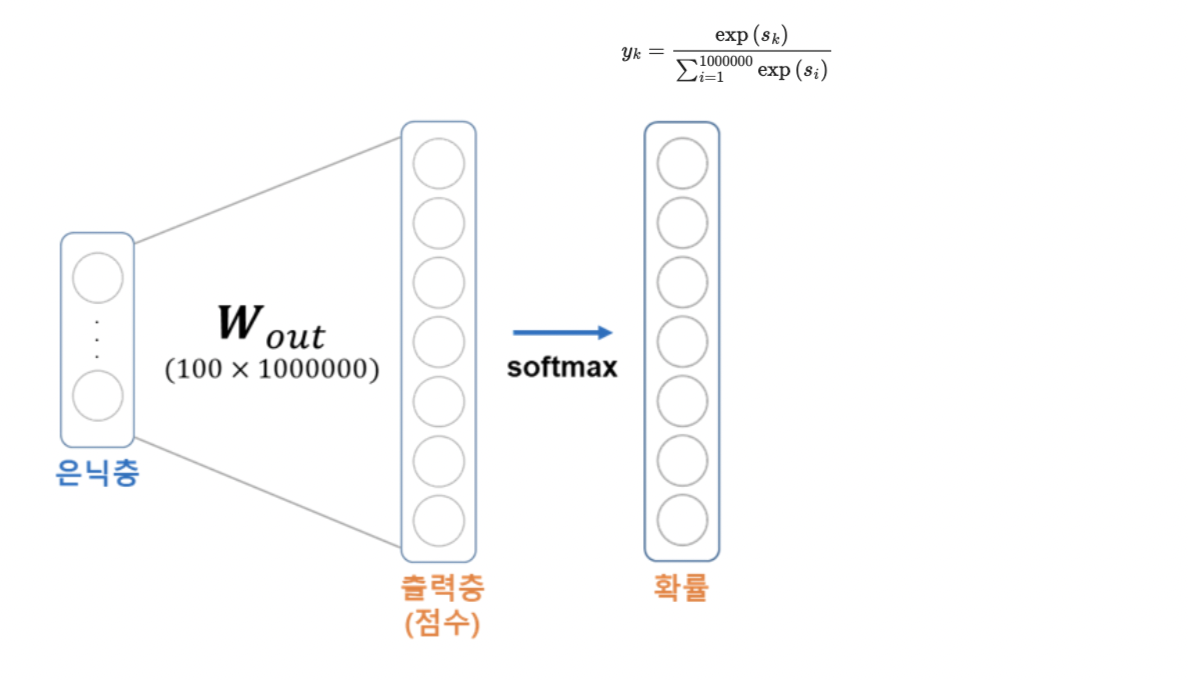
1. 은닉층의 뉴런과 가중치 행렬(Wout)의 곱
예를 들어 어휘가 100만개이고, 은닉층의 뉴런이 100개일 경우, 은닉층과 가중치 행렬의 곱을 계산하려면 시간이 오래걸림
2. Softmax 계층의 계산
어휘가 많아지면 Softmax의 계산량도 증가함.

### 4.2.2 다중 분류에서 이진 분류로
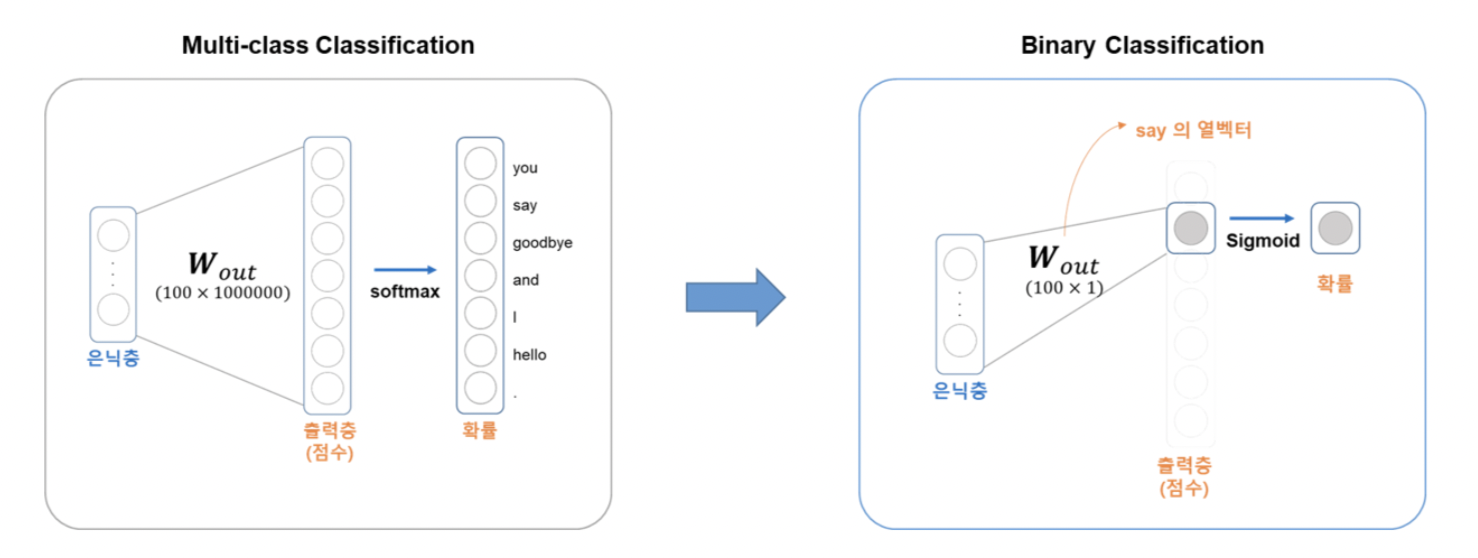
네거티브 샘플링의 핵심 아이디어는 다중 분류를 이진 분류로 근사하는 것에 있다.  
"you"와 "goodbye"를 줬을때 "say"를 출력하도록 하는 것이 아니라, "맥락이 you 와 goodbye이 일때, 타깃 단어는 say 입니까?"에 "yes"라는 대답을 들어야 하는 신경망을 만드는 것이 목표이다.

이렇게 하면 출력층에는 뉴런을 하나만 준비하면 된다. 출력층의 이 뉴런이 "say"의 점수를 출력하는 것이다.

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

다중 분류의 경우, 출력층에서는 'softmax', 손실 함수의 경우 '교차 엔트로피 오차'를 이용한다. 이진 분류의 경우, 출력층에서 'sigmoid'를, 손실 함수로는 '교차 엔트로피 오차'를 사용한다.

시그모이드 함수를 적용하면 0과 1사이의 실수로 변환되며, 여기서의 핵심은 결과값이 '확률'로 해석될 수 있다는 것이다. 
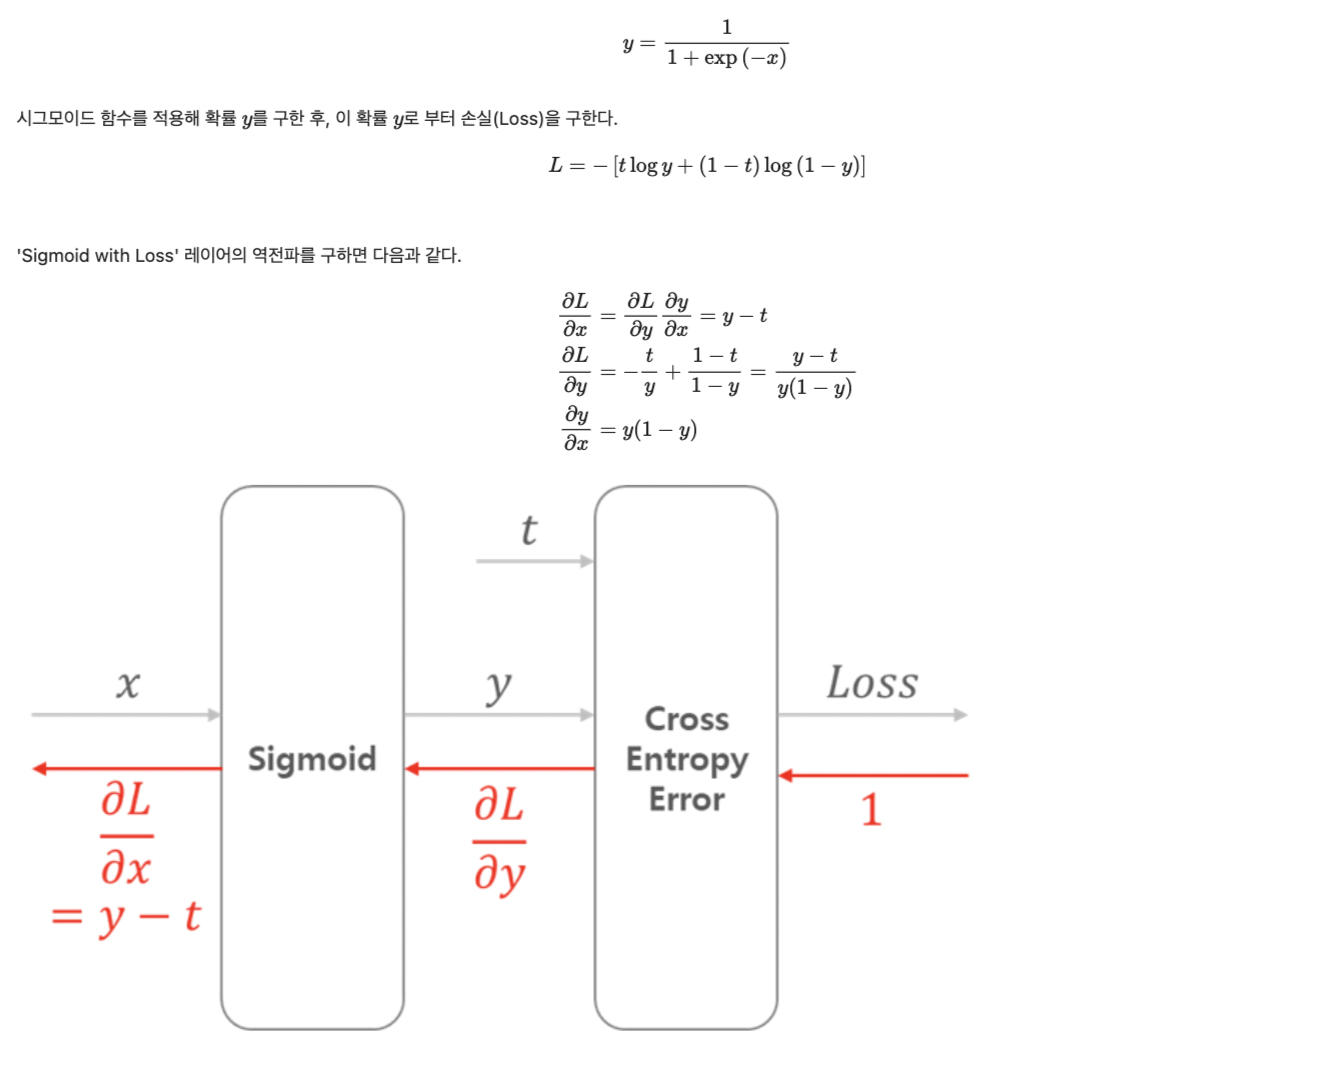

여기에서 'y'는 신경망이 출력한 확률이고, 't'는 정답 레이블이다. 따라서 두 값을 서로 뺀 값이 0에 가까우면(오차가 작으면) '작게' 학습하고, 1에 가까우면(오차가 크면) '크게' 학습하게 된다.

### 4.2.4 다중 분류에서 이진 분류로 구현
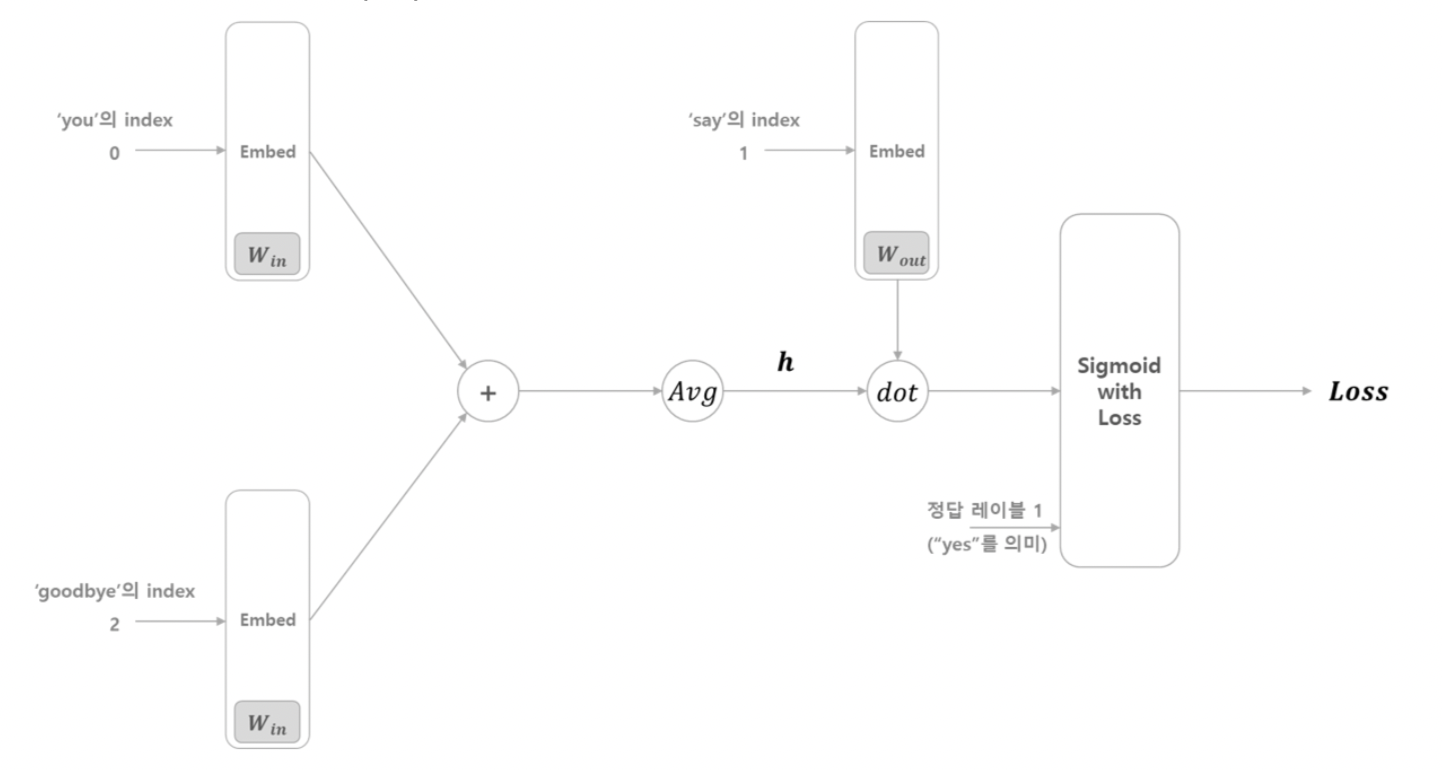

In [19]:
class EmbeddingDot:
    def __init__(self,W):
        self.embed = Embedding(W)
        self.params = self.embed.params #매개변수 저장
        self.grads = self.embed.grads  #기울기 저장
        self.cache = none # 순전파 시의 계산 결과를 잠시 유지하기 위한 변수
    
    def forward(self,h,idx): #은닉층의 뉴런과, 단어 ID의 넘파이 배열을 받음
        target_W=self.embed.forward(idx) #embedding 계층의 forward(idx) 호출
        out=np.sum(target_W*h,axis=1) #내적해서 행마다 전부 더해 최종 결과를 얻음
        
        self.cache=(h,target_W)
        return out
    
    def backward(self,dout):
        h, target_W = self.cache
        dout=dout.reshape(dout,shape[0],1)
        
        dtarget_W = dout*h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 4.2.4 네거티브 샘플링
우리는 이제 다중 분류에서 이진 분류로 변환할 수 있다. 하지만, 이것만으로는 문제가 해결되지 않는다. : 지금까지 긍정적인 예(정답)에 대해서만 학습했기 때문에. 따라서 오답을 입력하면 어떤 결화가 나올지 확실하지 않습니다. 우리는 이제 오답을 입력할때 sigmoid 계층의 출력이 0이 나오도록 해야함.

(입력, 타깃)의 정답인 예제와 오답(window_size내에 포함 되어 있지 않은 단어 쌍)인 네거티브 샘플을 사용한다. 여기서 네거티브 샘플은 모든 단어에 대한 네거티브 샘플이 아니라 몇 개(5개 또는 10개) 정도를 선택하여, 즉 샘플링해 사용한다. **즉, 적은 수의 부정적 예를 샘플링해 사용한다.**

### 4.2.6 네거티브 샘플링의 샘플링 기법
어떤식으로 샘플링 할 것인가 ?  
말뭉치에서 자주 등장하는 단어를 많이 추출하고, 드물게 등장하는 단어를 적게 추출하도록 한다. 말뭉치에서 단어별 출현 횟수를 바탕으로 확률분포를 구한다음, 그에 따라 샘플링 한다.
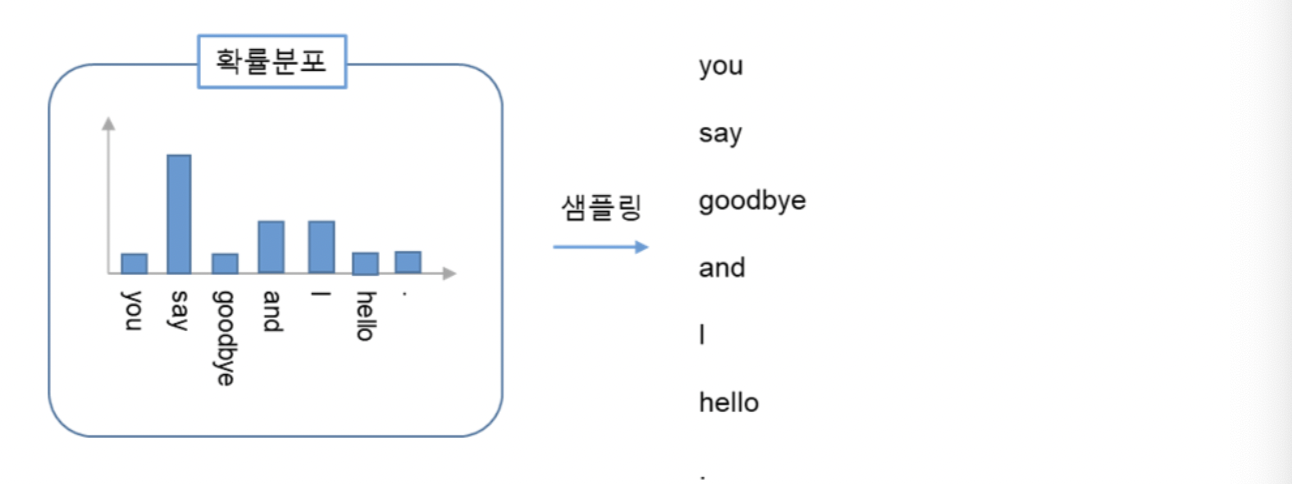

In [20]:
# 확률 분포에 따라 샘플링 하는 예제
import numpy as np

In [21]:
np.random.choice(10)

8

In [22]:
np.random.choice(10)

7

In [25]:
#words에서 하나만 무작위로 샘플링
words=['I','love','you','minji']
np.random.choice(words)

'minji'

In [26]:
#5개만 무작위로 샘플링(중복 있음)
np.random.choice(words,size=5)

array(['minji', 'I', 'love', 'you', 'I'], dtype='<U5')

In [27]:
#3개만 무작위로 샘플링(중복 없음)
np.random.choice(words,size=3,replace=False)

array(['minji', 'love', 'you'], dtype='<U5')

In [30]:
#확률분포에 따라 샘플링
p=[0.25,0.3,0.2,0.25]
np.random.choice(words, p=p)

'minji'

출현 확률이 낮은 단어를 '**버리지 않기**'위해서 원래 확률이 낮은 단어의 확률을 살짝 높이기 위해 0.75제곱을 해주어야 한다.

In [4]:
import sys
sys.path.append('/Users/minjikim/GitHub/NLP-studies/chap04/common')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None
        
        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1
            
        vocab_size = len(counts)
        self.vocab_size = vocab_size
        
        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]
            
        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)
        
    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        
        if not GPU:  # == CPU
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
            
            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0  # target이 뽑히지 않게 하기 위함
                p /= p.sum()  # 다시 정규화 해줌
                negative_sample[i, :] = np.random.choice(self.vocab_size,
                                                         size=self.sample_size,
                                                         replace=False, p=p)
                
        else:
            # GPU(cupy)로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, 
                                               size=(batch_size, self.sample_size), 
                                               replace=True, p=self.word_p)
            
        return negative_sample

ModuleNotFoundError: No module named 'common'

In [5]:
corpus=np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size=2

sampler = UnigramSampler(corpus,power,sample_size)
target=np.array([1,3,0])
negative_sample=sampler.get_negative_sample(target)
print(negative_sample)

NameError: name 'UnigramSampler' is not defined

### 네거티브 샘플링 구현

In [ ]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5): #인수로는 출력층 가중치 W, 말뭉치, 확률분포에 제곱할 값인 power, 오답의 샘플링 횟수인 sample_size
        self.sample_size = sample_size 
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
                
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]  # embed_dot에 해당하는 타겟이라는 의미인 듯
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh


In [3]:
import sys
sys.path.append('/Users/minjikim/GitHub/NLP-studies/chap04/cbow.py')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

ModuleNotFoundError: No module named 'common'